## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [38]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
%matplotlib inline

In [39]:
def calibration(images, show_images=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
#     images = glob.glob('../camera_cal/calibration*.jpg')
    for image in images:
       # Step through the list and search for chessboard corners
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        #If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            if show_images == True:
                img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # in order to plot using matplotlib(RGB)
                plt.figure()
                plt.imshow(img)
                plt.show()
    ret, C_mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return objpoints, imgpoints, C_mtx, dist_coef

In [40]:
def undistorted(img, C_mtx, coef):
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, C_mtx, coef, None, C_mtx)
    return img, undist

def plot_compare(inputs, name='', figure_size = (20,10)):
    if len(inputs)==1:
        plt.figure(figsize=figure_size)
        plt.imshow(inputs[0], cmap='gray')
        plt.title(name, fontsize=30)
        return 
    n = len(inputs)
    f, axs = plt.subplots(1,n,figsize=figure_size)
    for i in range(n):
        if len(inputs[i].shape) < 3:
            axs[i].imshow(inputs[i], cmap='gray')
            if len(name) == 3:
                axs[i].set_title(name[i-1], fontsize=25)
            elif name == 'YCrCb':
                title = ['Y', 'Cr', 'Cb']
                axs[i].set_title(title[i-1], fontsize=25)
            else:
                axs[i].set_title('Binary', fontsize=25)
        elif i == 0:
            img_ = cv2.cvtColor(inputs[i],cv2.COLOR_BGR2RGB)
            axs[i].imshow(img_)
            if name:
                axs[i].set_title(name, fontsize=25)
            else:
                axs[i].set_title('Original image', fontsize=25)
        else:
            img_ = cv2.cvtColor(inputs[i],cv2.COLOR_BGR2RGB)
            axs[i].imshow(img_)
#             axs[i].set_title('Undistorted image', fontsize=25)
            axs[i].set_title('Modified image', fontsize=25)
 
    return 

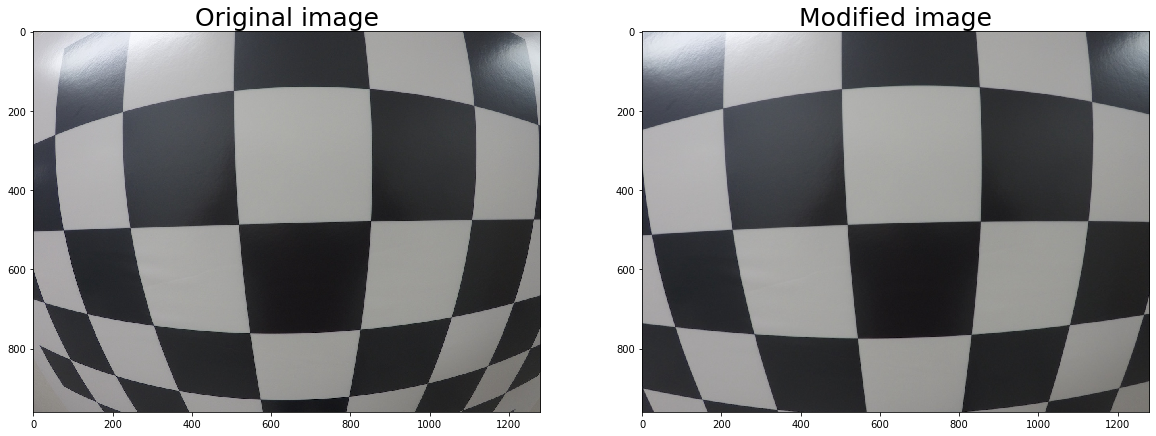

In [71]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') 
obj_points, img_points, C_mtx, dist_coef = calibration(images)

# show the undistorted result of calibration image
idx = 5
target = 'camera_cal/calibration'+str(idx)+'.jpg'
output_path = 'output_images/undistorted'+str(idx)+'.png'

test = 'camera_cal/test_image.jpg'
target_img = cv2.imread(test)
img_, undist_ = undistorted(target_img, C_mtx, dist_coef)
# cv2.imwrite(output_path, undist_)

plot_compare([img_, undist_])

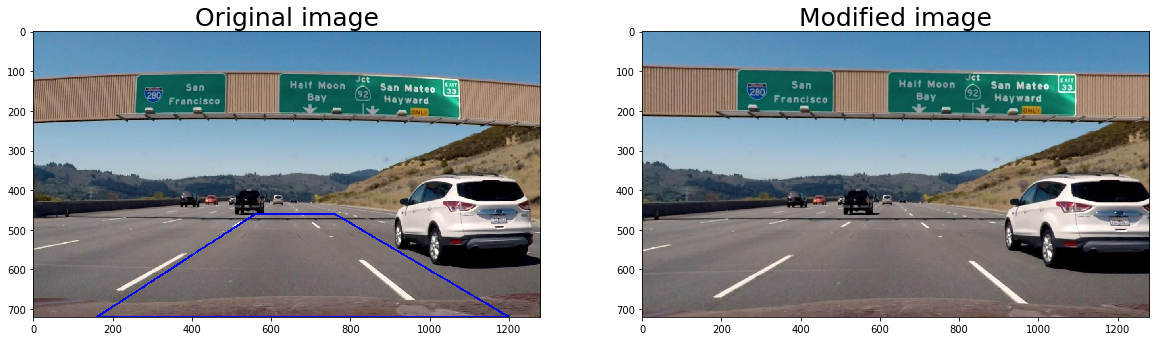

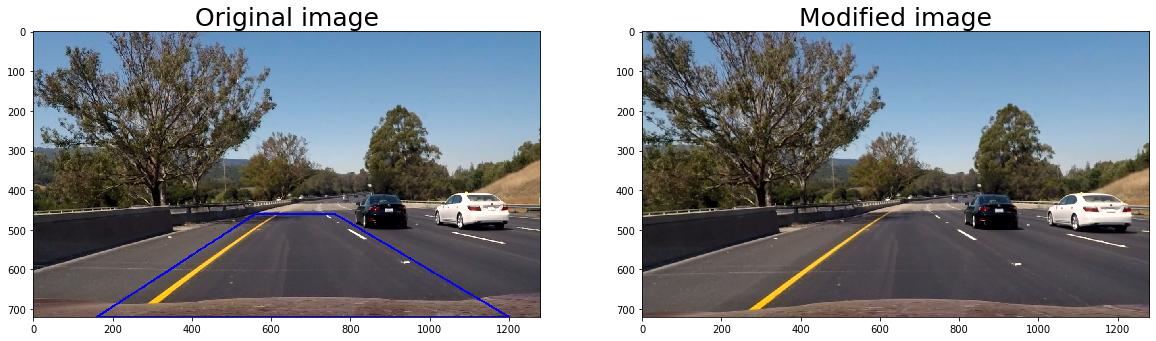

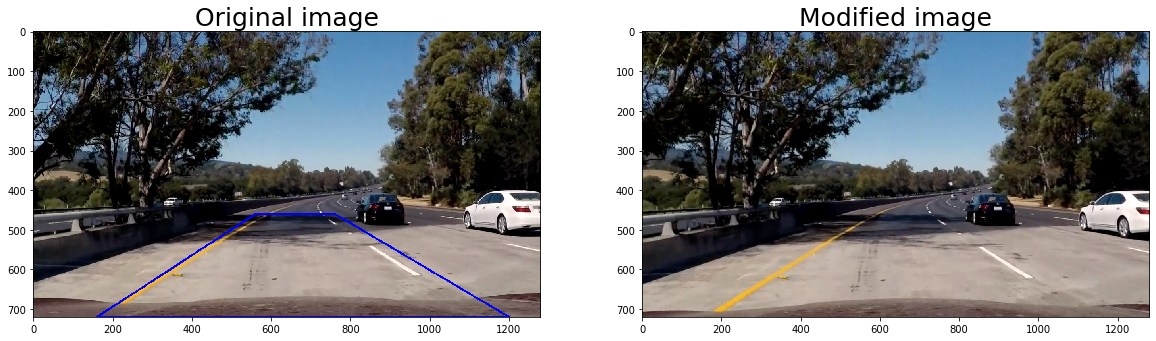

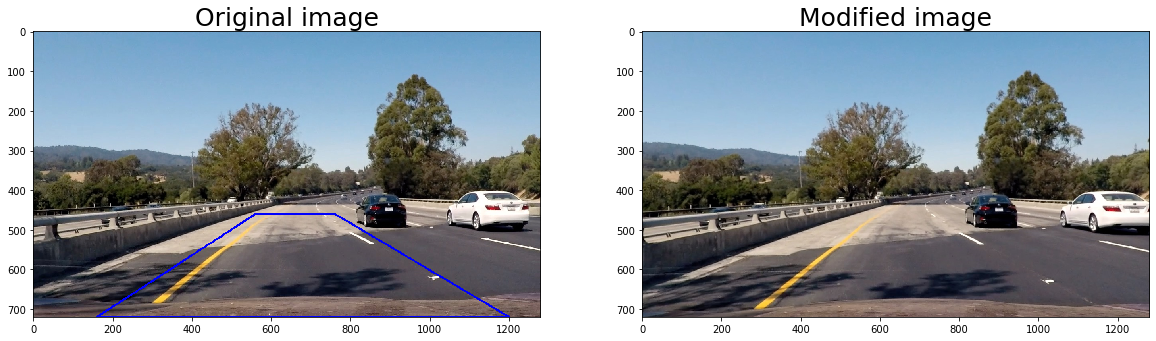

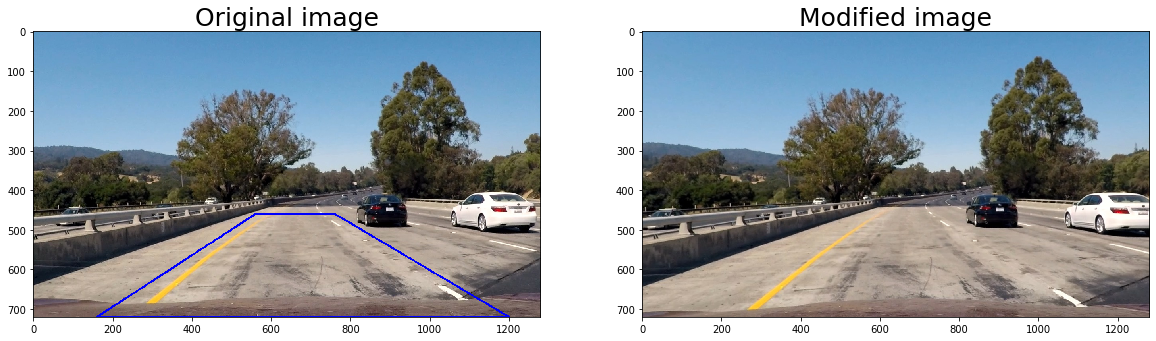

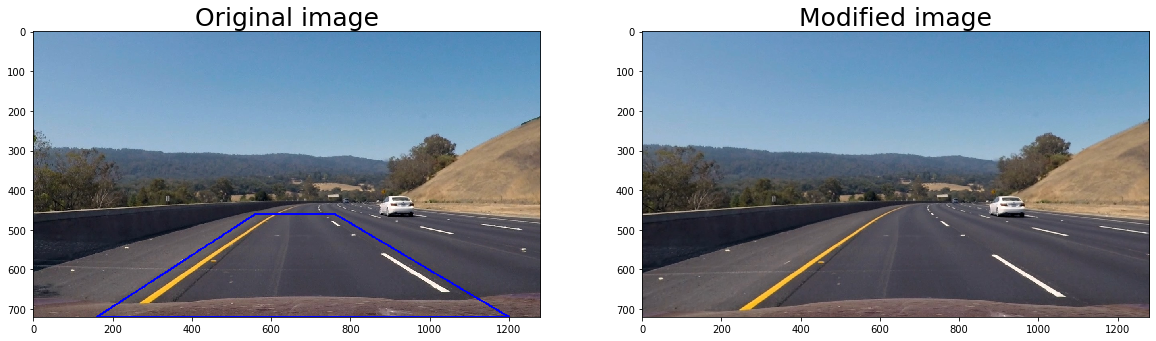

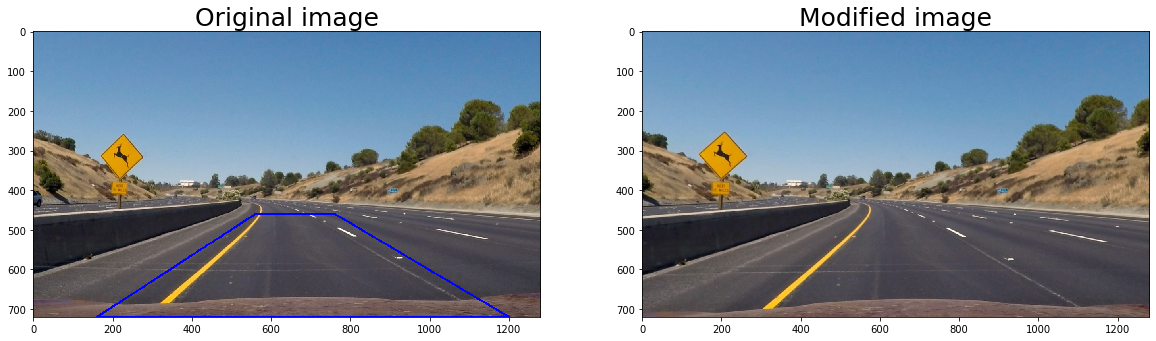

In [44]:
def draw_ROI(image, nodes):
#     img = cv2.imread(img_path)
    copy_img = np.copy(image) 
    thickness = 3
    color = (255, 0,0) # blue
    is_closed = True
    vertices = nodes.reshape(-1,1,2)
    return cv2.polylines(copy_img, [vertices], is_closed, color, thickness)

test_all = 'test_images/test*.jpg'

# define region of interest
top = 460 
bot = 720
lt, lb = 560, 160
rt, rb = 760, 1200
# top = 455 
# bot = 720
# lt, lb = 585, 190
# rt, rb = 705, 1130
nodes = np.array([[lt, top], [rt, top], [rb, bot], [lb, bot]], np.int32)

tests = glob.glob(test_all)
kernel_size = 3

i = 1
for test in tests:
    # camera calibration + undistortedi 
    test_img = cv2.imread(test)
    img, undist = undistorted(test_img, C_mtx, dist_coef)
    ROI = draw_ROI(img, nodes)
    plot_compare([ROI, undist])
#     cv2.imwrite('output_images/test_roi'+str(i)+'.png', ROI)
#     cv2.imwrite('output_images/test_un'+str(i)+'.jpg', undist)
    i+=1

In [46]:
# gradient thresholding
def thresholding(channel, threshold):
    binary = np.zeros_like(channel)
    binary[(channel > threshold[0]) & (channel <= threshold[1])] = 1
    return binary

def sobel_magnitude(gray, mag_thresh=(0,255),sobel_kernel=5):
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag = np.sqrt(sx*sx+sy*sy)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    
    return thresholding(scaled_mag, mag_thresh)


def sobel_direction(gray, dir_thresh=(0,np.pi/2), sobel_kernel=5):
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    phi = np.arctan2(np.absolute(sy), np.absolute(sx))
    
    return thresholding(phi, dir_thresh)


def sobel_xy(gray, coordinate, threshold=(0,255), sobel_kernel=5):
    if coordinate == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif coordinate == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        
    return thresholding(scaled_sobel, threshold) 

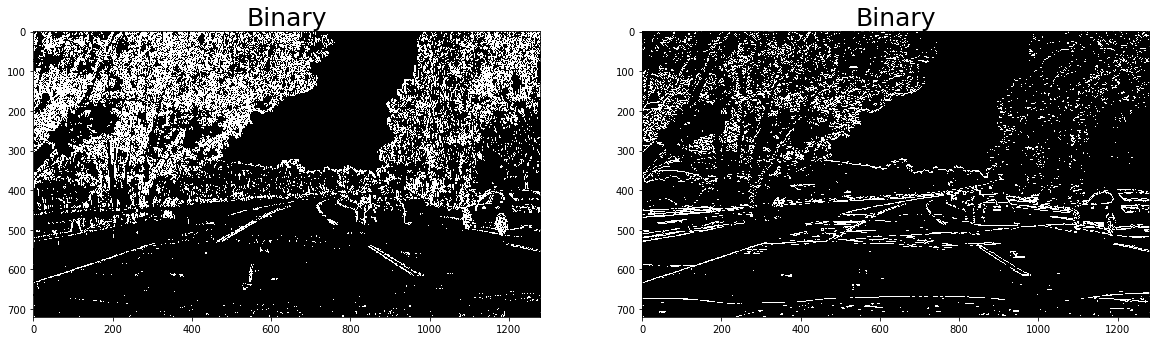

In [47]:
# apply Sobel operator 
# straight_lines1
test_path = 'test_images/test5.jpg'
binary1 = 'output_images/xy.png'
bina = 'output_images/all.png'
bina3 = 'output_images/mag_ori.png'
imgg = cv2.imread(test_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
b1 = sobel_magnitude(gray, (50,200), sobel_kernel = kernel_size)
b2 = sobel_direction(gray, (0.7,1.3), sobel_kernel = kernel_size)
b3 = sobel_xy(gray, 'x', (10,160), sobel_kernel = kernel_size)
b4 = sobel_xy(gray, 'y', (25,150), sobel_kernel = kernel_size)

sobel_combined = np.zeros_like(b1)
sobel_combined[((b3==1) & (b4==1)) | ((b1==1) & (b2==1))] = 1
sobel_combined2 = np.zeros_like(b1)
sobel_combined2[(b3==1) & (b4==1)] = 1
sobel_combined3 = np.zeros_like(b1)
sobel_combined3[(b1==1) & (b2==1)] = 1
# plt.imsave(binary1, sobel_combined2, cmap='gray') # cv2.imwrite(binary1, binary)
# plt.imsave(bina, sobel_combined, cmap='gray')
# plt.imsave(bina3, sobel_combined3, cmap='gray')
# plot_compare([imgg, sobel_combined, sobel_combined2])
plot_compare([b3,b4])

# plt.imsave('../output_images/sobel_x.png', b3, cmap='gray')
# plt.imsave('../output_images/sobel_y.png', b4, cmap='gray')
# plt.imsave('../output_images/sobel_mag.png', b1, cmap='gray')
# plt.imsave('../output_images/sobel_dir.png', b2, cmap='gray')

In [48]:
#color spaces: 'RGB', 'HSV', 'HLS', 'Lab', 'Luv', 'YUV', 'YCrCb' 
def color_thresholding(img, type_, threshold, show=False):
    if type_ == 'RGB':
        R_ch = img[:,:,2]
        G_ch = img[:,:,1]
        B_ch = img[:,:,0]
        # RGB thresholding works best on white lane pixels
        binary_R = thresholding(R_ch, threshold)
        binary_G = thresholding(G_ch, threshold)
        binary_B = thresholding(B_ch, threshold)
        ans = [binary_R, binary_G, binary_B]
        if show:
            ex = np.hstack((binary_R, binary_G, binary_B))
            plot_compare([ex], type_)
    elif type_ == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binary = thresholding(gray, threshold)
        if show:
            plot_compare([binary], type_+'scale')
        ans = [binary]
    elif type_ == 'HLS':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        H_ch = hls[:,:,0]
        L_ch = hls[:,:,1]
        S_ch = hls[:,:,2]
        binary_H = thresholding(H_ch, threshold)
        binary_L = thresholding(L_ch, threshold)
        binary_S = thresholding(S_ch, threshold)
        ans = [binary_H, binary_L, binary_S]
        if show:
            plot_compare([np.hstack((binary_H, binary_L, binary_S))], type_)
    elif type_ == 'HSV':
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H_ch = hsv[:,:,0]
        S_ch = hsv[:,:,1]
        V_ch = hsv[:,:,2]
        binary_H = thresholding(H_ch, threshold)
        binary_S = thresholding(S_ch, threshold)
        binary_V = thresholding(V_ch, threshold)
        ans = [binary_H, binary_S, binary_V]
        if show:
            plot_compare([np.hstack((binary_H, binary_S, binary_V))], type_)
    elif type_ == 'Lab':
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        L_ch = lab[:,:,0]
        a_ch = lab[:,:,1]
        b_ch = lab[:,:,2]
        binary_L = thresholding(L_ch, threshold)
        binary_a = thresholding(a_ch, threshold)
        binary_b = thresholding(b_ch, threshold)
        ans = [binary_L, binary_a, binary_b]
        if show:
            plot_compare([np.hstack((binary_L, binary_a, binary_b))], type_)
    elif type_ == 'Luv':
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
        L_ch = luv[:,:,0]
        u_ch = luv[:,:,1]
        v_ch = luv[:,:,2]
        binary_L = thresholding(L_ch, threshold)
        binary_u = thresholding(u_ch, threshold)
        binary_v = thresholding(v_ch, threshold)
        ans = [binary_L, binary_u, binary_v]
        if show:
            plot_compare([np.hstack((binary_L, binary_u, binary_v))], type_)
    elif type_ == 'YUV':
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        Y_ch = yuv[:,:,0]
        U_ch = yuv[:,:,1]
        V_ch = yuv[:,:,2]
        binary_Y = thresholding(Y_ch, threshold)
        binary_U = thresholding(U_ch, threshold)
        binary_V = thresholding(V_ch, threshold)
        ans = [binary_Y, binary_U, binary_V]
        if show:
            plot_compare([np.hstack((binary_Y, binary_U, binary_V))], type_)
    elif type_ == 'YCrCb':
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y_ch = ycrcb[:,:,0]
        cr_ch = ycrcb[:,:,1]
        cb_ch = ycrcb[:,:,2]
        binary_y = thresholding(y_ch, threshold)
        binary_cr = thresholding(cr_ch, threshold)
        binary_cb = thresholding(cb_ch, threshold)
        ans = [binary_y, binary_cr, binary_cb]
        if show:
            plot_compare([np.hstack((binary_y, binary_cr, binary_cb))], type_)
    return ans
        

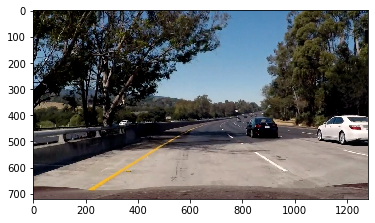

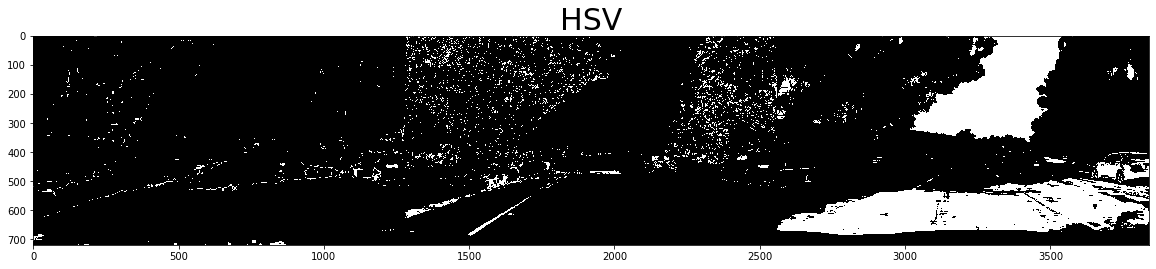

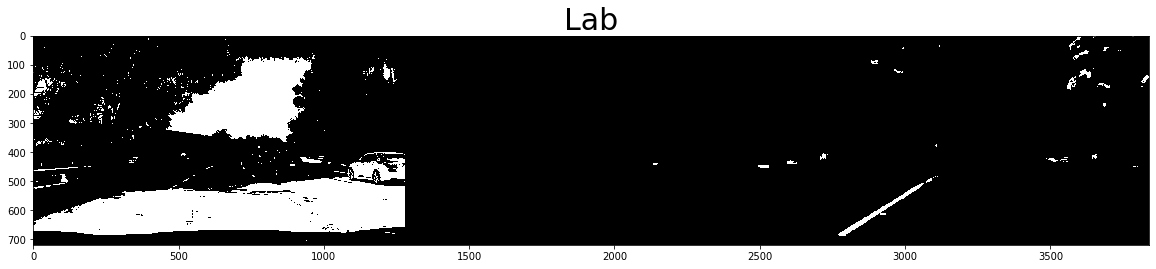

In [72]:
# get binary from color space transform
color_spaces = ['RGB','gray','HSV', 'HLS', 'Lab', 'Luv', 'YUV', 'YCrCb']
test_path = 'test_images/test5.jpg'
temp = cv2.imread(test_path)
threshold = (170, 250)
plt.imshow(cv2.cvtColor(temp, cv2.COLOR_RGB2BGR))
chs = color_thresholding(temp, 'HSV', threshold, True)
chs = color_thresholding(temp, 'Lab', (150, 250), True)
# for space in color_spaces:
#     chs = color_thresholding(temp, space, threshold, True)
#     plt.imsave('../output_images/color_'+space+'1.png', chs[0], cmap='gray')
#     plt.imsave('../output_images/color_'+space+'2.png', chs[1], cmap='gray')
#     plt.imsave('../output_images/color_'+space+'3.png', chs[2], cmap='gray')


In [73]:
# from normal view to bird's eye(top-down) view
def perspective_transform(undist, src, dst, nx=9,ny=6):
    if len(undist.shape) < 3:
        gray = np.copy(undist)
    else:
        gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # create warped image using linear interpolation
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

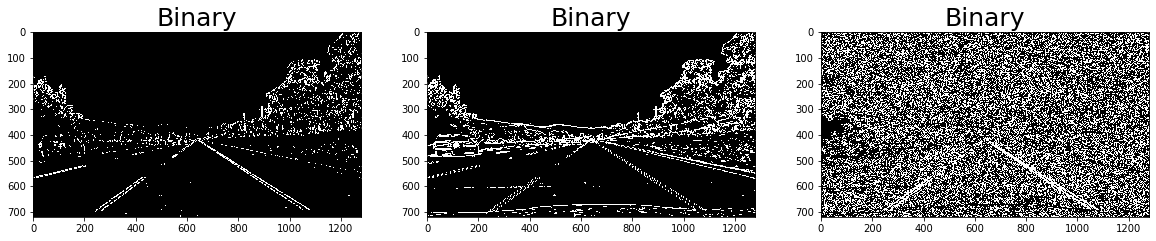

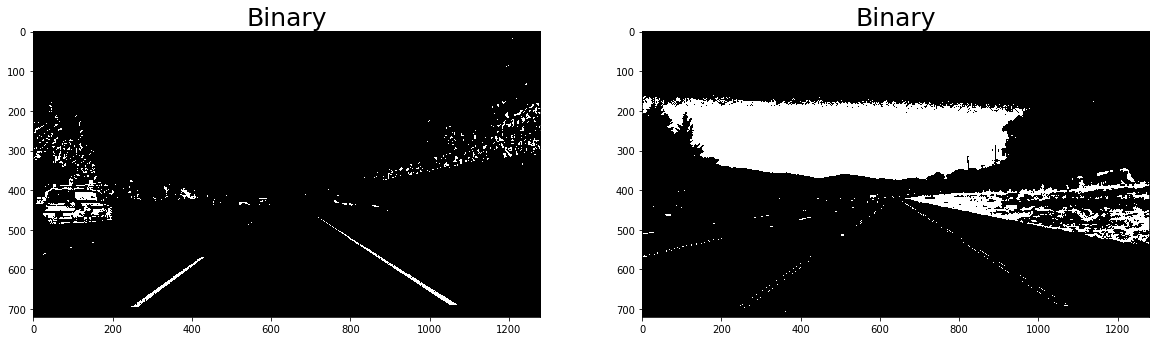

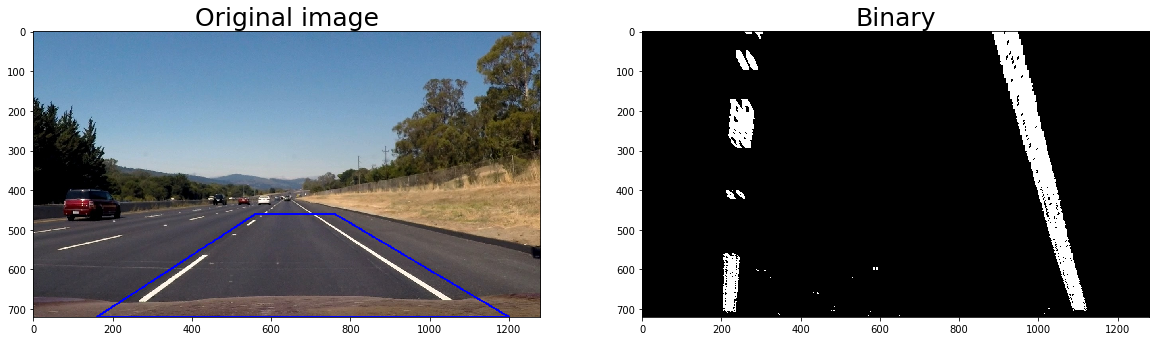

In [116]:
def testing1(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = image.shape
    offset = 200
    # define the source and destination points for perspective transform
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[lb, 0],[rb,0],[rb,bot],[lb,bot]])
    dst1 = np.float32([[offset, offset], [image_size[0]-offset, offset], [image_size[0]-offset, image_size[1]-offset], [offset, image_size[1]-offset]])

    img4, undist4 = undistorted(image, C_mtx, dist_coef)
    # color and gradient thresholding
    color_threshold = (170,255)
    channels = color_thresholding(undist4, 'HLS', color_threshold)
    channels2 = color_thresholding(undist4, 'YUV', (155,200))
    ch = channels[2] # single channel 
    ch2 = channels2[0]
    gray4 = cv2.cvtColor(undist4, cv2.COLOR_BGR2GRAY)

    sobel_threshold = (20,120)
    threshold_y = (100,200)
    dir_threshold = (0.7, 1.3)
    sobel_m = sobel_magnitude(gray4, sobel_threshold)
    sobel_d = sobel_direction(gray4, dir_threshold)
    sobel = sobel_xy(gray4, 'x', sobel_threshold) # use x direction is better since the lane lines are usually vertical
    sobely = sobel_xy(gray4, 'y', threshold_y)

    combined5 = np.zeros_like(sobel)
    combined5[(sobel_m==1)&(sobel_d==1)] = 1
    combined_final = np.zeros_like(sobel)
    combined_final[((ch==1))|(sobel==1)] = 1
    combined6 = np.zeros_like(sobel)
    combined6[((ch==1))|((sobel_m==1)&(sobel_d==1))|(sobel==1)] = 1

    # combined_final
    top_down, per_M, Minv = perspective_transform(combined_final, src, dst)
    ROI = draw_ROI(img4, nodes)
    ROI_ = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
    
    plot_compare([sobel, sobel_m, sobel_d])
    plot_compare([ch, ch2])
    # plot_compare([combined5, combined_final])
    plot_compare([ROI, top_down])
    # plt.imsave('output_images/pers1.png', ROI_)
    # plt.imsave('output_images/pers2.png', top_down, cmap='gray')
    return 

# perform perspective transform
path = 'test_images/straight_lines2.jpg'
image = cv2.imread(path)
testing1(image)


In [52]:
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
class Line():
    mp_y = 30/720 # meter per pixel
    mp_x = 3.7/700 # meter per pixel
    
    def __init__(self, size = 9):
        self.buffer_size = size
        # was the line detected in the last iteration?
        self.detected = False  

        self.current_fitx = None
        self.recent_fitx = collections.deque([], maxlen=self.buffer_size) 
        self.current_fit = np.ndarray([])
        self.recent_fit = collections.deque([], maxlen=self.buffer_size)   
        self.yp = None
        self.bestx = None     
        self.best_fit = None 
        self.radius_of_curvature = None 
        self.check = True

In [59]:
def histogram(binary, size):
    histogram = np.sum(binary[size[0]//2:,:], axis=0) # 1/3 of the height from bottom
    indices = find_peaks_cwt(histogram, np.arange(1,150), min_length=150)
    
    if len(indices) > 1:
        left_peak, *_, right_peak = indices
    else:
        midpoint = np.int(histogram.shape[0]//2)
        left_peak = np.argmax(histogram[:midpoint])
        right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_peak, right_peak

def poly_fitting(leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def sliding_window(warped_binary, visual=False, nwindows = 10):
    # detect lane pixels and fit to find the lane boundary
    size_ = warped_binary.shape
    
    # Current positions to be updated later for each window in nwindows
    leftx_current, rightx_current = histogram(warped_binary, size_)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    
    min_pix = 45 # Set minimum number of pixels found to recenter window
    margin = 90 # Set the width of the windows +/- margin
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(size_[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for w in range(nwindows):
        # find out the boundaries of each window
        win_y_low = size_[0] - (w+1)*window_height
        win_y_high = size_[0] - w*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw rectangles 
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # identify the nonzero pixels in x and y within the window, nonzero() returns indices of non-zero elements
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit, right_fit = poly_fitting(leftx, lefty, rightx, righty)
    # Generate x and y values for plotting
    ploty = np.linspace(0, size_[0]-1, size_[0])
    ll.yp = ploty
    rl.yp = ploty
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ll.detected = True
    ll.current_fit = left_fit
    ll.current_fitx = left_fitx
    rl.detected = True
    rl.current_fit = right_fit
    rl.current_fitx = right_fitx
    
    # check the result, add to the buffer and get the average.
    ring_buffer()
    
    if(visual):
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        poly_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
        cv2.polylines(out_img, [poly_left], False, (255,255,0), 2) 
        poly_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
        cv2.polylines(out_img, [poly_right], False, (255,255,0), 2) 
    
    return out_img

def search_around_previous(binary_warped, visual = False):
    global ll, rl
    # HYPERPARAMETER
    margin = 55 # searching region
    
    size_ = binary_warped.shape
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # find out the points that are inside the margin using previous points(current_fit)
    left_lane_inds = ((nonzerox > (ll.current_fit[0]*(nonzeroy**2) + ll.current_fit[1]*nonzeroy + 
                    ll.current_fit[2] - margin)) & (nonzerox < (ll.current_fit[0]*(nonzeroy**2) + 
                    ll.current_fit[1]*nonzeroy + ll.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (rl.current_fit[0]*(nonzeroy**2) + rl.current_fit[1]*nonzeroy + 
                    rl.current_fit[2] - margin)) & (nonzerox < (rl.current_fit[0]*(nonzeroy**2) + 
                    rl.current_fit[1]*nonzeroy + rl.current_fit[2] + margin)))
    
    if left_lane_inds is None or right_lane_inds is None:
        return None
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit = poly_fitting(leftx, lefty, rightx, righty)
    
     # Generate x and y values for plotting
    ploty = np.linspace(0, size_[0]-1, size_[0])
    ll.yp = ploty
    rl.yp = ploty

    ll.current_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rl.current_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ll.current_fit = left_fit
    rl.current_fit = right_fit
    
    # check the result, add to the buffer and get the average.
    check = ring_buffer()
    if check == "BAD":
        return None
    
    ## Visualization ##
    if visual:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([ll.current_fitx-margin, ll.yp]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([ll.current_fitx+margin, ll.yp])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([rl.current_fitx-margin, rl.yp]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rl.current_fitx+margin, rl.yp])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
#         poly_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
#         cv2.polylines(out_img, [poly_left], False, (255,255,0), 2) 
#         poly_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
#         cv2.polylines(out_img, [poly_right], False, (255,255,0), 2) 
    
    return result

In [117]:
# calculation curvature( of polynomial function in pixels)
def curvature(ploty, left_fit, right_fit):
    global ll
    y_eval = np.max(ploty)*ll.mp_y
    A1 = left_fit[0]*ll.mp_x/(ll.mp_y*ll.mp_y)
    B1 = left_fit[1]*ll.mp_x/ll.mp_y
    A2 = right_fit[0]*ll.mp_x/(ll.mp_y*ll.mp_y)
    B2 = right_fit[1]*ll.mp_x/ll.mp_y
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*A1*y_eval + B1)**2)**1.5) / np.absolute(2*A1)
    right_curverad = ((1 + (2*A2*y_eval + B2)**2)**1.5) / np.absolute(2*A2)
    
    return left_curverad, right_curverad

def get_offset(img_size):
    global rl, ll
    camera_mid = img_size[1]//2
    # center position of the car away from the center of lane
    lane_mid = (ll.current_fitx[-1]+rl.current_fitx[-1])/2
    
    offset = (lane_mid - camera_mid)*ll.mp_x # in meter
    offset = int(offset*1000)/1000
    return offset

def visualize(img_size, topdown, undist, offset, fit_result, Minv):
    # Create an image to draw the lines on
    global rl, ll
    warp_zero = np.zeros_like(topdown).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([ll.bestx, ll.yp]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rl.bestx, rl.yp])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (img_size[1], img_size[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)
    
    text_xmin = 30
    font_scale = 1.1
    cv2.putText(result, '{}  Right lane curvature : {}m'.format(str(rl.check), int(rl.radius_of_curvature)), (text_xmin,90), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    cv2.putText(result, '{}  Left lane curvature : {}m'.format(str(ll.check), int(ll.radius_of_curvature)), (text_xmin,135), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    if offset > 0: 
        # to the left
        cv2.putText(result, 'Car center: {} m to the left'.format(np.absolute(offset)), (text_xmin,45), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
    else:
        # to the right
        cv2.putText(result, 'Car center: {} m to the right'.format(np.absolute(offset)), (text_xmin,45), fontFace = 16, fontScale = font_scale, color=(255,255,255), thickness = 2)
        
    # this is used to display a subwindow for debugging
    bird_eye = True
    if bird_eye:
        sub_size = (580, 340)
        TopDown = cv2.resize(fit_result, sub_size)
        result[:sub_size[1],img_size[1]-sub_size[0]:] = TopDown
    
    return result

def sanity_check():
    # check if similar curvature, parallel, horizontal distance between lanes, 
    global rl, ll
    ll.check=True
    rl.check=True
    
    if len(ll.recent_fit) > 2:
        # really bad detection 
        dif_cur = rl.current_fitx-ll.current_fitx
        dif_min = np.amin(dif_cur)
#         dif_prev = rl.recent_fitx[-1][-1]-ll.recent_fitx[-1][-1]
        if dif_min*ll.mp_x < 0.4:
            ll.check = False
            rl.check = False
            return "BAD"
        factor = 2.5
        min_curv = 400 
        max_curv = 40000 
        left_cur_roc, right_cur_roc = curvature(ll.yp, ll.current_fit, rl.current_fit)
#         left_prev_roc, right_prev_roc = curvature(ll.yp, ll.recent_fit[-1], rl.recent_fit[-1])
#         if left_cur_roc > left_prev_roc*factor or left_cur_roc < left_prev_roc/factor: 
#             ll.check = False
#         if right_cur_roc > right_prev_roc*factor or right_cur_roc < right_prev_roc/factor:
#             rl.check = False
            
        if left_cur_roc > max_curv or left_cur_roc < min_curv: 
            ll.check = False
        if right_cur_roc > max_curv or right_cur_roc < min_curv:
            rl.check = False
            
        if not ll.check or not rl.check:
            return 
        
    return 


def ring_buffer(): 
    global rl, ll
    # if pass sanity check, add this detection, else discard it.
    result = sanity_check()
    if ll.check:
        ll.recent_fit.append(ll.current_fit)
        ll.recent_fitx.append(ll.current_fitx)
        n_ = len(ll.recent_fit)
        ll.best_fit = np.sum(ll.recent_fit, axis=0)/n_
        ll.bestx = np.sum(ll.recent_fitx, axis=0)/n_
        
    if rl.check:
        rl.recent_fit.append(rl.current_fit)
        rl.recent_fitx.append(rl.current_fitx)
        n_ = len(rl.recent_fit)
        rl.best_fit = np.sum(rl.recent_fit, axis=0)/n_
        rl.bestx = np.sum(rl.recent_fitx, axis=0)/n_
    return result


def lane_finding(top_down):
    global rl, ll
    if rl.detected == False and ll.detected == False:
        # sliding window
        print('Sliding window!')
        output = sliding_window(top_down, True) 
    else:
        # targeted search
        output = search_around_previous(top_down, True)
        if output is None:
            rl.detected = False
            ll.detected = False
            # sliding window
            output = sliding_window(top_down, True)
    return output


685.7811398493213 1065.3956506733832


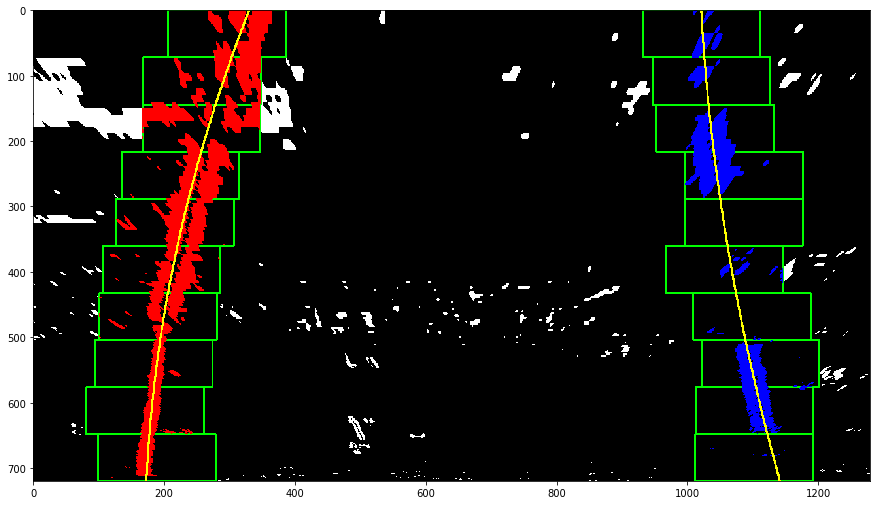

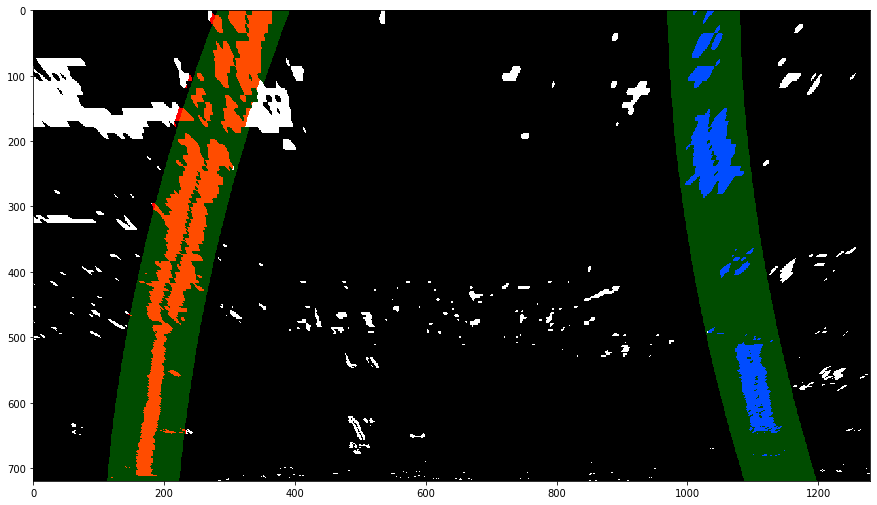

In [61]:
ll, rl = Line(), Line()
warped_binary = np.copy(top_down)
plt.figure(figsize = (15,10))
output = sliding_window(warped_binary, True)
plt.imshow(output)
plt.imsave('output_images/windows.png', output, cmap='gray')

lc, rc = curvature(ll.yp, ll.best_fit, rl.best_fit)

print(lc, rc)

output = search_around_previous(warped_binary, True)
# print(output)
plt.figure(figsize = (15,10))
plt.imshow(output)
plt.imsave('output_images/targeted.png', output, cmap='gray')

In [96]:
def pipeline(origin_image):
    # get precalculated camera calibration factors
    global C_mtx ,dist_coef 
    global rl, ll
    
    # distortion correction
    origin, undist = undistorted(origin_image, C_mtx, dist_coef)
    img = np.copy(origin)
    size = img.shape
    
    # thresholded binary image using color space transform, gradient thresholding
    color_threshold = (170,255)
    color_space = 'HLS'
    channels = color_thresholding(undist, color_space, color_threshold)
    ch = channels[2] # S - single channel 

    sobel_threshold = (20, 110)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    sobelx = sobel_xy(gray, 'x', sobel_threshold)
    sobely = sobel_xy(gray, 'y', sobel_threshold)
    sobelm = sobel_magnitude(gray, sobel_threshold)
    sobeld = sobel_direction(gray, (0.7,1.3))
    
    binary = np.zeros_like(sobelx) # &(ch2==1)
#     binary[((ch==1))| ((sobelx==1))|((sobelm==1)&(sobeld==1))] = 1
    binary[((ch==1))| ((sobelx==1))] = 1
    
    # set region of interest - ROI
    top, bot = 460, 720
    lt, lb = 560, 160
    rt, rb = 760, 1200
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[lb, 0],[rb,0],[rb,bot],[lb,bot]])

    # perspective transform - warped binary
    top_down, per_M, Minv = perspective_transform(binary, src, dst)
    
    good_fit = lane_finding(top_down)
    
    # determine the curvature of the lane and vehicle position wrt center
    ll.radius_of_curvature, rl.radius_of_curvature = curvature(ll.yp, ll.best_fit, rl.best_fit)
    offset = get_offset(size)
    
    # unwarped and draw the lane
    result = visualize(size, top_down, undist, offset, good_fit, Minv)
    
    return result


Sliding window!


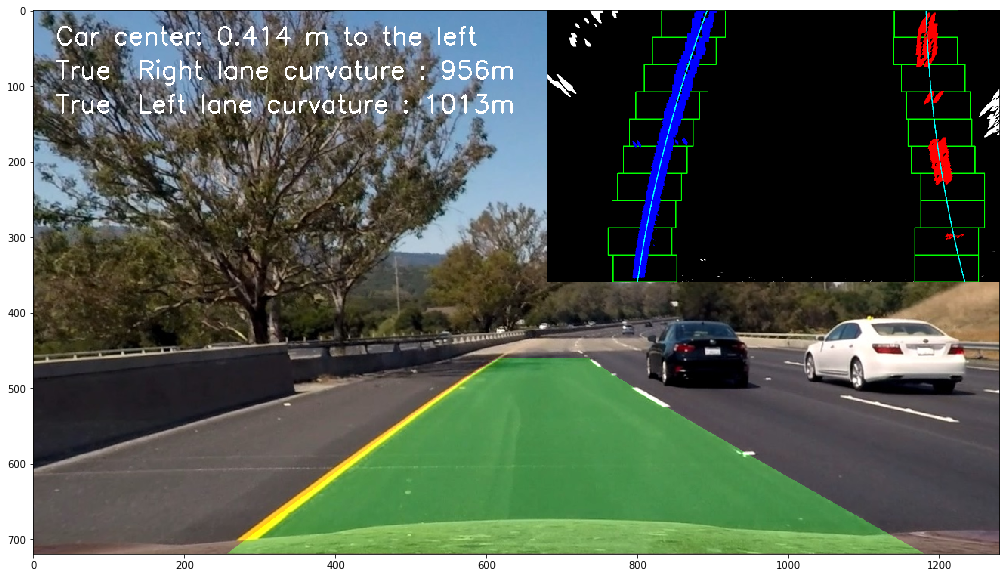

In [102]:
# testing pipeline
rl, ll = Line(), Line()
path1 = 'test_images/test6.jpg'
temp = cv2.imread(path1)
ans = pipeline(temp)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(ans, cv2.COLOR_RGB2BGR))


In [103]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# global variables
bufferSize = 15
ll = Line(bufferSize) # left line
rl = Line(bufferSize) # right line

output_path = 'videos/project.mp4'
video_path = 'videos/project_video.mp4'

clip1 = VideoFileClip(video_path) #.subclip(32,47)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Sliding window!
Moviepy - Building video videos/project.mp4.
Moviepy - Writing video videos/project.mp4



Moviepy - Done !
Moviepy - video ready videos/project.mp4
CPU times: user 5min 30s, sys: 41 s, total: 6min 11s
Wall time: 3min 33s


In [104]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

## And so on and so forth...

Here we make an approximation that the road is a flate plane. 
For 

In [29]:
def pipeline2(origin_image):
    # get precalculated camera calibration factors
    global C_mtx ,dist_coef 
    global rl, ll
    
    # distortion correction
    origin, undist = undistorted(origin_image, C_mtx, dist_coef)
    img = np.copy(origin)
    size = img.shape
    
    # thresholded binary image using color space transform, gradient thresholding
    color_threshold = (170,255)
    color_space = 'HLS'
    channels = color_thresholding(undist, color_space, color_threshold)
#     channels2 = color_thresholding(undist, 'RGB', color_threshold)
#     channels3 = color_thresholding(undist, 'Lab', (170,252))
    
    ch = channels[2] # S - single channel 
#     ch2 = channels2[0] # R - single channel 
#     ch3 = channles3[2]

    sobel_threshold = (20, 100)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    sobelx = sobel_xy(gray, 'x', sobel_threshold)
    sobely = sobel_xy(gray, 'y', sobel_threshold)
    sobelm = sobel_magnitude(gray, sobel_threshold)
    sobeld = sobel_direction(gray, (0.7,1.3))
    
    binary = np.zeros_like(sobelx) # &(ch2==1)
    binary[((ch==1))| ((sobelx==1)&(sobely==1))|((sobelm==1)&(sobeld==1))] = 1
#     binary[(ch==1)| (sobelx==1)] = 1
    
    # set region of interest - ROI
    top, bot = 460, 720
    lt, lb = 620, 300
    rt, rb = 820, 1200
    src = np.float32([[lt, top], [rt, top], [rb, bot], [lb, bot]])
    dst = np.float32([[lb, 0],[rb,0],[rb,bot],[lb,bot]])

    # perspective transform - warped binary
    top_down, per_M, Minv = perspective_transform(binary, src, dst)
    #lane searching
    good_fit = lane_finding(top_down)
    
    # determine the curvature of the lane and vehicle position wrt center
    ll.radius_of_curvature, rl.radius_of_curvature = curvature(ll.yp, ll.best_fit, rl.best_fit)
    offset = get_offset(size)
    
    # unwarped and draw the lane
    result = visualize(size, top_down, undist, offset, good_fit, Minv)
    
    return result


In [30]:
# more challenging video
ll = Line(15) # left line
rl = Line(15) # right line

output_path1 = 'videos/challenge1.mp4'
video_path1 = 'videos/challenge_video.mp4'

clip1 = VideoFileClip(video_path1)
white_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path1, audio=False)


t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Sliding window!
Moviepy - Building video videos/challenge1.mp4.
Moviepy - Writing video videos/challenge1.mp4



Moviepy - Done !
Moviepy - video ready videos/challenge1.mp4
CPU times: user 2min 8s, sys: 14.5 s, total: 2min 23s
Wall time: 1min 16s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path1))

In [162]:
# more challenging video
ll = Line(15) # left line
rl = Line(15) # right line

output_path2 = 'videos/challenge2.mp4'
video_path2 = 'videos/harder_challenge_video.mp4'

clip1 = VideoFileClip(video_path2)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path2, audio=False)

                                                                     
t:   0%|          | 1/300 [3:28:50<1040:44:32, 12530.68s/it, now=None]
                                                                      
t:   1%|          | 2/375 [2:21:38<00:49,  7.56it/s, now=None]

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Sliding window!
Moviepy - Building video ../output_images/challenge2.mp4.
Moviepy - Writing video ../output_images/challenge2.mp4





t:   0%|          | 2/1199 [00:00<01:54, 10.42it/s, now=None]

t:   0%|          | 3/1199 [00:00<02:24,  8.28it/s, now=None]

t:   0%|          | 4/1199 [00:00<02:53,  6.90it/s, now=None]

t:   0%|          | 5/1199 [00:00<03:07,  6.38it/s, now=None]

t:   1%|          | 6/1199 [00:00<03:10,  6.26it/s, now=None]

t:   1%|          | 7/1199 [00:01<03:09,  6.30it/s, now=None]

t:   1%|          | 8/1199 [00:01<03:10,  6.24it/s, now=None]

t:   1%|          | 9/1199 [00:01<03:14,  6.12it/s, now=None]

t:   1%|          | 10/1199 [00:01<03:11,  6.20it/s, now=None]

t:   1%|          | 11/1199 [00:01<03:08,  6.32it/s, now=None]

t:   1%|          | 12/1199 [00:01<03:10,  6.24it/s, now=None]

t:   1%|          | 13/1199 [00:02<03:08,  6.30it/s, now=None]

t:   1%|          | 14/1199 [00:02<03:09,  6.27it/s, now=None]

t:   1%|▏         | 15/1199 [00:02<03:08,  6.29it/s, now=None]

t:   1%|▏         | 16/1199 [00:02<03:05,  6.37it/s, now=None]

t:   1%|▏         | 17/1199 [00:02<03:03,  6.4

t:  19%|█▉        | 233/1199 [00:41<03:10,  5.08it/s, now=None]

t:  20%|█▉        | 234/1199 [00:41<03:06,  5.17it/s, now=None]

t:  20%|█▉        | 235/1199 [00:42<03:01,  5.31it/s, now=None]

t:  20%|█▉        | 236/1199 [00:42<02:58,  5.41it/s, now=None]

t:  20%|█▉        | 237/1199 [00:42<02:59,  5.36it/s, now=None]

t:  20%|█▉        | 238/1199 [00:42<02:58,  5.38it/s, now=None]

t:  20%|█▉        | 239/1199 [00:42<02:56,  5.44it/s, now=None]

t:  20%|██        | 240/1199 [00:42<02:54,  5.51it/s, now=None]

t:  20%|██        | 241/1199 [00:43<02:58,  5.37it/s, now=None]

t:  20%|██        | 242/1199 [00:43<02:57,  5.38it/s, now=None]

t:  20%|██        | 243/1199 [00:43<02:55,  5.45it/s, now=None]

t:  20%|██        | 244/1199 [00:43<02:53,  5.49it/s, now=None]

t:  20%|██        | 245/1199 [00:43<02:58,  5.35it/s, now=None]

t:  21%|██        | 246/1199 [00:44<02:57,  5.38it/s, now=None]

t:  21%|██        | 247/1199 [00:44<02:53,  5.48it/s, now=None]

t:  21%|██        | 248/1

t:  39%|███▊      | 463/1199 [01:23<02:16,  5.37it/s, now=None]

t:  39%|███▊      | 464/1199 [01:23<02:14,  5.46it/s, now=None]

t:  39%|███▉      | 465/1199 [01:23<02:09,  5.67it/s, now=None]

t:  39%|███▉      | 466/1199 [01:23<02:06,  5.80it/s, now=None]

t:  39%|███▉      | 467/1199 [01:23<02:09,  5.63it/s, now=None]

t:  39%|███▉      | 468/1199 [01:23<02:07,  5.72it/s, now=None]

t:  39%|███▉      | 469/1199 [01:24<02:06,  5.79it/s, now=None]

t:  39%|███▉      | 470/1199 [01:24<02:04,  5.85it/s, now=None]

t:  39%|███▉      | 471/1199 [01:24<02:06,  5.77it/s, now=None]

t:  39%|███▉      | 472/1199 [01:24<02:05,  5.81it/s, now=None]

t:  39%|███▉      | 473/1199 [01:24<02:02,  5.92it/s, now=None]

t:  40%|███▉      | 474/1199 [01:24<02:00,  6.00it/s, now=None]

t:  40%|███▉      | 475/1199 [01:25<02:02,  5.91it/s, now=None]

t:  40%|███▉      | 476/1199 [01:25<02:02,  5.90it/s, now=None]

t:  40%|███▉      | 477/1199 [01:25<02:00,  5.98it/s, now=None]

t:  40%|███▉      | 478/1

t:  58%|█████▊    | 693/1199 [02:03<01:30,  5.61it/s, now=None]

t:  58%|█████▊    | 694/1199 [02:03<01:28,  5.68it/s, now=None]

t:  58%|█████▊    | 695/1199 [02:03<01:30,  5.55it/s, now=None]

t:  58%|█████▊    | 696/1199 [02:03<01:30,  5.54it/s, now=None]

t:  58%|█████▊    | 697/1199 [02:03<01:28,  5.66it/s, now=None]

t:  58%|█████▊    | 698/1199 [02:04<01:26,  5.78it/s, now=None]

t:  58%|█████▊    | 699/1199 [02:04<01:28,  5.65it/s, now=None]

t:  58%|█████▊    | 700/1199 [02:04<01:28,  5.64it/s, now=None]

t:  58%|█████▊    | 701/1199 [02:04<01:27,  5.70it/s, now=None]

t:  59%|█████▊    | 702/1199 [02:04<01:26,  5.76it/s, now=None]

t:  59%|█████▊    | 703/1199 [02:05<01:27,  5.65it/s, now=None]

t:  59%|█████▊    | 704/1199 [02:05<01:27,  5.67it/s, now=None]

t:  59%|█████▉    | 705/1199 [02:05<01:25,  5.75it/s, now=None]

t:  59%|█████▉    | 706/1199 [02:05<01:23,  5.92it/s, now=None]

t:  59%|█████▉    | 707/1199 [02:05<01:23,  5.88it/s, now=None]

t:  59%|█████▉    | 708/1

t:  77%|███████▋  | 923/1199 [02:46<00:48,  5.67it/s, now=None]

t:  77%|███████▋  | 924/1199 [02:46<00:47,  5.84it/s, now=None]

t:  77%|███████▋  | 925/1199 [02:47<00:46,  5.85it/s, now=None]

t:  77%|███████▋  | 926/1199 [02:47<00:45,  5.98it/s, now=None]

t:  77%|███████▋  | 927/1199 [02:47<00:44,  6.13it/s, now=None]

t:  77%|███████▋  | 928/1199 [02:47<00:43,  6.18it/s, now=None]

t:  77%|███████▋  | 929/1199 [02:47<00:44,  6.03it/s, now=None]

t:  78%|███████▊  | 930/1199 [02:47<00:44,  6.06it/s, now=None]

t:  78%|███████▊  | 931/1199 [02:48<00:44,  6.05it/s, now=None]

t:  78%|███████▊  | 932/1199 [02:48<00:43,  6.14it/s, now=None]

t:  78%|███████▊  | 933/1199 [02:48<00:44,  5.98it/s, now=None]

t:  78%|███████▊  | 934/1199 [02:48<00:44,  6.01it/s, now=None]

t:  78%|███████▊  | 935/1199 [02:48<00:43,  6.11it/s, now=None]

t:  78%|███████▊  | 936/1199 [02:48<00:42,  6.14it/s, now=None]

t:  78%|███████▊  | 937/1199 [02:49<00:43,  6.09it/s, now=None]

t:  78%|███████▊  | 938/1

t:  96%|█████████▌| 1150/1199 [03:26<00:09,  5.03it/s, now=None]

t:  96%|█████████▌| 1151/1199 [03:26<00:09,  5.15it/s, now=None]

t:  96%|█████████▌| 1152/1199 [03:26<00:08,  5.34it/s, now=None]

t:  96%|█████████▌| 1153/1199 [03:26<00:08,  5.45it/s, now=None]

t:  96%|█████████▌| 1154/1199 [03:26<00:08,  5.41it/s, now=None]

t:  96%|█████████▋| 1155/1199 [03:27<00:08,  5.49it/s, now=None]

t:  96%|█████████▋| 1156/1199 [03:27<00:07,  5.56it/s, now=None]

t:  96%|█████████▋| 1157/1199 [03:27<00:07,  5.63it/s, now=None]

t:  97%|█████████▋| 1158/1199 [03:27<00:07,  5.54it/s, now=None]

t:  97%|█████████▋| 1159/1199 [03:27<00:07,  5.59it/s, now=None]

t:  97%|█████████▋| 1160/1199 [03:27<00:06,  5.65it/s, now=None]

t:  97%|█████████▋| 1161/1199 [03:28<00:06,  5.71it/s, now=None]

t:  97%|█████████▋| 1162/1199 [03:28<00:06,  5.64it/s, now=None]

t:  97%|█████████▋| 1163/1199 [03:28<00:06,  5.70it/s, now=None]

t:  97%|█████████▋| 1164/1199 [03:28<00:06,  5.71it/s, now=None]

t:  97%|██

Moviepy - Done !
Moviepy - video ready ../output_images/challenge2.mp4
CPU times: user 5min 51s, sys: 38.9 s, total: 6min 29s
Wall time: 3min 36s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path2))